In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
!mkdir data
trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
valset = datasets.MNIST('data', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

A subdirectory or file data already exists.


# CNN classifier

In [19]:
def score(y_pred, y_true):
    winners = y_pred.argmax(dim=1)
    return (winners == y_true).sum() / winners.size(0)

In [17]:
class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.sequence = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(in_channels=10, out_channels=30, kernel_size=3),
            nn.MaxPool2d(kernel_size=3),
            nn.Flatten(),
            nn.Linear(120, 10),
            nn.Softmax()
        )
        
    def forward(self, x):
        return self.sequence(x)

EPOCH	 1


c:\Users\marcu\anaconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Loss:	 1.677772911118546
Train Accuracy	 0.7986074
Val Loss:	 1.5978950102617786
Val Accuracy	 0.8674363
---------------------------
EPOCH	 2
Train Loss:	 1.5904416185198054
Train Accuracy	 0.8731177
Val Loss:	 1.584729552268982
Val Accuracy	 0.87778664
---------------------------
EPOCH	 3
Train Loss:	 1.51849830176022
Train Accuracy	 0.9461287
Val Loss:	 1.4891165783450862
Val Accuracy	 0.97442275
---------------------------
EPOCH	 4
Train Loss:	 1.4891374221742788
Train Accuracy	 0.97473013
Val Loss:	 1.4863386708460036
Val Accuracy	 0.97611463
---------------------------
EPOCH	 5
Train Loss:	 1.4849409433061889
Train Accuracy	 0.97831154
Val Loss:	 1.4818294936684286
Val Accuracy	 0.98158836
---------------------------
EPOCH	 6
Train Loss:	 1.4826008908784212
Train Accuracy	 0.98064363
Val Loss:	 1.4797409453969093
Val Accuracy	 0.9830812
---------------------------
EPOCH	 7
Train Loss:	 1.4802295124607046
Train Accuracy	 0.98227614
Val Loss:	 1.4796355590698824
Val Accuracy	 

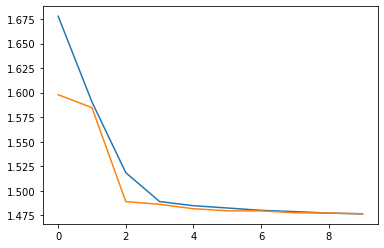

In [20]:
model = ConvModel()

n_epochs = 10
learning_rate = 1e-3
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
train_acc = []
val_acc = []
for epoch in range(1, n_epochs + 1):
    print('EPOCH\t', epoch)
    batch_train_losses = []
    batch_val_losses = []
    batch_train_acc = []
    batch_val_acc = []
    
    for x_batch, y_batch in trainloader:
        y_onehot = nn.functional.one_hot(y_batch, num_classes=10).float()
        
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_onehot)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_train_losses.append(loss.item())
        batch_train_acc.append(score(y_pred, y_batch))
        
    train_losses.append(np.mean(batch_train_losses))
    train_acc.append(np.mean(batch_train_acc))
    
    print('Train Loss:\t', train_losses[-1])
    print('Train Accuracy\t', train_acc[-1])
        
    with torch.no_grad():
        for x_batch, y_batch in valloader:
            y_onehot = nn.functional.one_hot(y_batch, num_classes=10).float()
        
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_onehot)
            
            batch_val_losses.append(loss.item())
            batch_val_acc.append(score(y_pred, y_batch))
        
        val_losses.append(np.mean(batch_val_losses))
        val_acc.append(np.mean(batch_val_acc))
        
    print('Val Loss:\t', val_losses[-1])
    print('Val Accuracy\t', val_acc[-1])
    print('---------------------------')

fig, ax = plt.subplots()
ax.plot(np.arange(epoch), train_losses)
ax.plot(np.arange(epoch), val_losses)
plt.show()

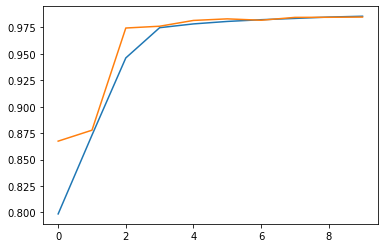

In [23]:
fig, ax = plt.subplots()
ax.plot(np.arange(epoch), train_acc)
ax.plot(np.arange(epoch), val_acc)
plt.show()

# Autoencoder CNN

In [69]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.sequence = nn.Sequential(
            nn.Conv2d(1, 10, 3),
            nn.MaxPool2d(3),
            nn.Flatten(),
            nn.Linear(64*10, 10),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.sequence(x)
    

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.sequence = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 28*28),
            # nn.ReLU(),
            nn.Unflatten(1, (1, 28, 28))
        )
        
    def forward(self, x):
        return self.sequence(x)
        

In [70]:
encoder = Encoder()
decoder = Decoder()

model_parameters = list(encoder.parameters()) + list(decoder.parameters())
lr = 1e-3
optimizer = torch.optim.Adam(model_parameters, lr=lr)

loss_fn = nn.MSELoss()

n_epochs = 100
losses = []
for epoch in range(1, n_epochs+1):
    print('EPOCH', epoch)
    batch_losses = []
    for x, _ in trainloader:
        encoding = encoder(x)
        out = decoder(encoding)
        
        loss = loss_fn(out, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
    losses.append(np.mean(batch_losses))
    print('Loss', losses[-1])
    

EPOCH 1
Loss 0.23469085653008684
EPOCH 2
Loss 0.20147510243059474
EPOCH 3
Loss 0.18980970349647344
EPOCH 4
Loss 0.18239060905315221
EPOCH 5
Loss 0.17977015542259603
EPOCH 6
Loss 0.17757842017770575
EPOCH 7
Loss 0.1756714514927315
EPOCH 8
Loss 0.17406682007666083
EPOCH 9
Loss 0.17288336397678866
EPOCH 10
Loss 0.17187072665515993
EPOCH 11
Loss 0.1710237481160713
EPOCH 12
Loss 0.17012275240695807
EPOCH 13
Loss 0.16939808634806797
EPOCH 14
Loss 0.1688209314590324
EPOCH 15
Loss 0.16822508042618664
EPOCH 16
Loss 0.16760009420769556
EPOCH 17
Loss 0.16706750146361557
EPOCH 18
Loss 0.16658348324837716
EPOCH 19
Loss 0.1661398659732296
EPOCH 20
Loss 0.16572489411528432
EPOCH 21
Loss 0.16541824772604494
EPOCH 22
Loss 0.1651402909809084
EPOCH 23
Loss 0.16491708365966007
EPOCH 24
Loss 0.1646303521957733
EPOCH 25
Loss 0.16442432124286827
EPOCH 26
Loss 0.16429525964867586
EPOCH 27
Loss 0.1640682284003382
EPOCH 28
Loss 0.16392958550247302
EPOCH 29
Loss 0.16372571583749898
EPOCH 30
Loss 0.16359850573641

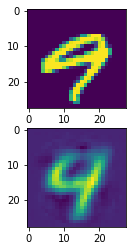

In [102]:
for x, _ in valloader:
    fig, ax = plt.subplots(2)
    ax[0].imshow(x[0][0])
    
    encoded = encoder(x)
    out = decoder(encoded).detach().numpy()
    
    ax[1].imshow(out[0][0])
    
    break